<font size=6>**Optimizing code using Graphics Processing Units**</font>

<div style="border: 1px solid lightgray; padding: 10px; background-color: #f9f9f9;">
<font size=1>
Summer School for AstroStatistics in Crete, 2025

The content presented in this notebook is the original work of the authors, unless specified otherwise.
Any publicly available material incorporated is properly credited to its respective sources.
All references to published papers, datasets, and software tools are duly acknowledged.
The original content of this notebook is licensed under the GNU General Public License v3.0 (GNU GPLv3).
</font>
</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">


# Introduction

This notebook presents **GPU parallelization**, a coding framework/paradigm that can be used to dramatically speed up scientific computations. 

Graphics Processing Units (GPUs) are massively parallel hardware devices, historically used for rendering graphics. These devices are capable of perfoming an incredible amount of computations in real time, leading to the realistic graphics we routinely see in video games nowadays. However, the same computational power can be harnessed to perform scientific computations. This has led, somewhat ironically, to the development of powerful GPUs without a port to connect a monitor to. 

![](images/geforce256.webp "Title")  |  ![](images/nvidia-l4-qtr-left.jpeg)
:-------------------------:|:-------------------------:
A GPU from 1999 - notice the gaming roots ([original image](https://9gag.com/gag/av8jBpW?utm_source=copy_link&utm_medium=post_share))|  One of the latest General Purpose GPUs (an Nvidia L4 Tensor Core). Notice the lack of a monitor port.


The power of GPUs is ''raw'', which means that the tremendous speed up they can offer will not necessarily occur for any type of computations. A necessary ''code analysis'' step needs to be taken first. Specifically, quoting from [Barsdell et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010MNRAS.408.1936B/abstract): 

> <i>Algorithms with well-defined memory access patterns and high arithmetic intensity stand to receive the greatest performance boost from massively parallel architectures.</i>

In simpler words, if your code needs to do the same ''dum'', mundane, repetitive task multiple times (the more the better), then GPUs could be very helpful. This is in contrast to, quoting from the same paper:

> <i> [Algorithms] that involve a significant amount of decision-making may struggle to take advantage of the available processing power.</i>

# Have you heard of "vectorization"?

You might have heard of this term when working with some python libraries. Let's assume we want to multiply each number in an array with a fixed number (this could be another simple operation, like dividing, adding, subtracting, taking the square or some other power, a sine or cosine, etc).

The simplest (sequential) programming way to achieve this would be by writing a loop that goes over each element in the array and performs the required operation. Vectorization consists in rewriting the loop in such a way as to process the elements of the array in parallel. For example, if the array is of size 500, we could use 5 threads working at the same time, each processing 100 elements, with the total computation being roughly 5 times faster. Obviously, the more threads available the faster the computation. For example, if there is one thread per array element we could speed this up by a factor of 500.

The name "vectorization" comes from an analogy with doing operations between vectors, for example, the case of multiplying an array, or vector, by a single number, or scalar, is analogous to (but, importantly, not the same) defining a new vector of equal size to the array with all its elements set to the same scalar value and then multiplying the two vectors element-by-element simultaneously.

<img src="images/np-vectorize-thumbnail.png" alt="drawing" width="400"/>

# Examples of good GPU use cases

Here is a tentative list of problems/algorithms that are efficiently parallelizable:
* Ray shooting
* N-body calculations
* Neural networks

On the other hand, a bad/not optimal GPU algorithm would be one that requires constant communication between threads/kernels, or does not have a well-defined memory access pattern (we will see this in more detail). **add image of accessing memory here**.

# Managing memory

The last point raises an important question related to GPUs: *memory management*. Lets imagine the following example of calculating the mean of 1,000,000 values. We can break the problem into 2 steps:

1. Define 1,000 threads that will work in parallel each tasked with adding 1,000 numbers (in a loop).
2. Wait for all partial sums to be computed.
3. Add the computed 1,000 partial sums in a loop to obtain the final sum.
4. Divide by 1,000,000 to get the mean (this can also happen in each thread to avoid very large numbers).

**Using parallel CPUs**: Imagine that we want to distribute this task to 1,000 CPUs, most likely available in several computing nodes of a computing cluster. To make things a bit more clear, let's assume 50 nodes of 20 CPUs each. Each CPU will run one loop and provide a partial sum, but in order to do so it must have access to the particular chunk of 1,000 numbers it needs to add. Because our CPUs are physically located across different machines, we need to divide the inital 1,000,000 numbers into chunks of memory, each containing a set of 1,000 numbers, and transfer them to each node accordingly. The first 20 chunks will go to the first node, the next 20 to the second, etc. Once each CPU completes their task of calculating a partial sum, which is just a number, the resulting 1,000 partial sums will need to be gathered to a single node for a CPU to take over the task of summing them up. This is how MPI works. **add image/sketch explaining this**

<img src="images/memory_sketch.jpg" alt="drawing" width="400"/>

**Using a GPU**: GPUs are separate hardware devices (think of them as a computing node within your computer) that have mutliple threads available, usually thousands. The GPU threads have some limitations compared to CPUs, but let's not digress here, just remember that they are a bit 'dummer' and can handle simpler tasks. GPUs have their own memory independently from the RAM of the computer, just as a separate node would have. Hence, similarly to the CPU case above, we need to transfer the 1,000,000 numbers to GPU memory and then transfer the final result back to the CPU so that we can further process it, save it, make a plot, etc. The important difference here is that all memory will be visible to all the GPU threads, therefore, we have to **instruct each thread which chunk of memory to work on**.

# A simple $\chi^2$

One such ''ridiculously parallelizable'' problem is the computation of a $\chi^2$ metric: $$\Large \chi^2 = \sum_{i=0}^{N} \frac{(d_i - \mathcal{M}_i)^2}{\sigma_i^2}$$
where $d$ is a measurement, $\sigma$ its associated uncertainty, and $\mathcal{M}$ a model prediction. The index $i$ runs through a collection of such measurements that have a logical association, for example, a time-series or an image. 

Below we show an example of fitting a straight line to some time-series/light curve data. The model is:
$$ \mathcal{M}(t|\alpha,\beta) = \alpha x + \beta$$
where $\alpha$ and $\beta$ are the free parameters - in this case, the slope and intercept of a straight line. Given some values of the free parameters, we can calculate the $\chi^2$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set up a fancy plot style (you can comment it out without consequences)
import sys; sys.path.append('../src'); import plot_style
import time

Length of data:  15


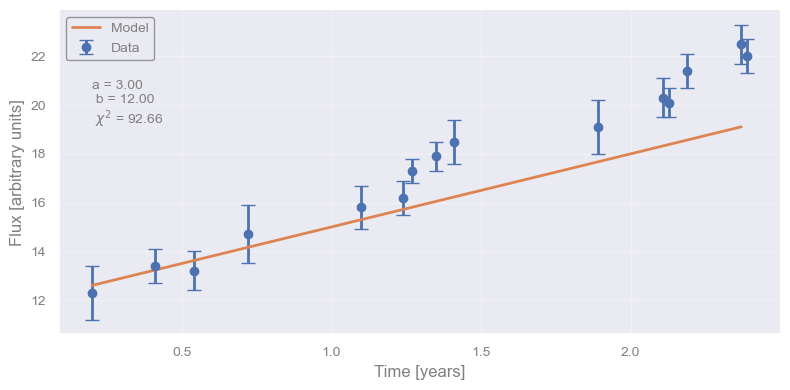

In [2]:
### First, we define the light curve data as a list of observations (time, flux, error)
measurements = np.array([
    [0.20, 12.3, 1.1],
    [0.41, 13.4, 0.7],
    [0.54, 13.2, 0.8],
    [0.72, 14.7, 1.2],
    [1.10, 15.8, 0.9],
    [1.24, 16.2, 0.7],
    [1.27, 17.3, 0.5],
    [1.35, 17.9, 0.6],
    [1.41, 18.5, 0.9],
    [1.89, 19.1, 1.1],
    [2.11, 20.3, 0.8],
    [2.13, 20.1, 0.6],
    [2.19, 21.4, 0.7],
    [2.39, 22.0, 0.7],
    [2.37, 22.5, 0.8]
],dtype=np.float64)
t = measurements[:,0] # time in units of years
f = measurements[:,1] # flux in arbitrary units
e = 1*measurements[:,2] # error in the same units as flux
N_data = len(f)
print("Length of data: ", N_data)


### Second, we obtain the model.
### In this case it is just a straight line with 2 free parameters, which we set to some random values.
### We evaluate the model at the (time) location of each data point.
def my_model(x,alpha,beta):
    y = alpha*x + beta
    return y

a = 3 # in units of flux/time
b = 12 # in units of flux
model = [ my_model(x,a,b) for x in t ]



### Third, we compare the model to the data by calculating the corresponding chi^2
def chi2_cpu(d,e,m,N_data):
    chi2 = 0.0
    for i in range(0,N_data):
        chi2_term = (d[i]-m[i])/e[i]
        chi2 = chi2 + np.power(chi2_term,2)
    return chi2

chi2 = chi2_cpu(f,e,model,N_data)



### Finally, let's plot the data, our model, and its chi^2 value
data_plot = plt.errorbar(t, f, yerr=e, fmt='o', capsize=5, label="Data")

tt = np.linspace(t[0],t[-1],50) # some t values on which to calculate the model, just for plotting purposes
model = [my_model(t,a,b) for t in tt]
model_plot = plt.plot(tt,model,label="Model")

# Cosmetics (labels, legend, etc)
my_text = "a = %.2f \n b = %.2f \n $\chi^2$ = %.2f" % (a,b,chi2)
plt.text(0.2,20, my_text, horizontalalignment='left', verticalalignment='center')
plt.legend()
plt.xlabel('Time [years]')
plt.ylabel('Flux [arbitrary units]')

plt.show()

# Brute force parameter estimation - CPU vs GPU

How do we find the best-fit (lowest $\chi^2$) a,b parameters?
Or how do we explore the entire a,b parameter space and get confidence intervals on a,b ?

In [3]:
### Plot the chi^2 and likelihood surfaces as a function of a,b
def plot_likelihood_surf(x,y,z,z_like):
    
    fig, axs = plt.subplots(1,2)
    #fig.set_figheight(9)
    fig.set_figwidth(15)

    #im = axs[0].pcolor(a_grid,b_grid,chi2_surf,cmap='viridis')
    im = axs[0].contour(x,y,z,levels=[2,5,10,20,50,100,200,400,800],cmap="viridis")
    fig.colorbar(im,ax=axs[0],label=r'$\chi^2$')
    axs[0].set_ylabel('b - intercept [flux]')
    axs[0].set_xlabel('a - slope [time/flux]')

    im = axs[1].pcolor(x,y,z_like,cmap='viridis')
    fig.colorbar(im,ax=axs[1],label=r'$e^{-\chi^2}$')
    axs[1].set_ylabel('b - intercept [flux]')
    axs[1].set_xlabel('a - slope [time/flux]')

    plt.show()
    

### Calculate the full chi^2 on the CPU (3 nested loops)
def CPU_full_chi2(a_grid,b_grid,N_a,N_b,t,f,e,N_data):
    chi2_surf = np.empty([N_a,N_b])
    like_surf = np.empty([N_a,N_b])
    for i in range(0,len(a_grid)):
        for j in range(0,len(b_grid)):
            #model = [ my_model(x,a_grid[i],b_grid[j]) for x in t ]
            #chi2_tmp = chi2_cpu(f,e,model,N_data)
            
            chi2 = 0.0
            for k in range(0,N_data):
                my_model = a_grid[i]*t[k] + b_grid[j]
                chi2_term = (f[k]-my_model)/e[k]
                chi2 = chi2 + np.power(chi2_term,2)
            
            like = np.exp(-chi2)
            
            chi2_surf[i][j] = chi2
            like_surf[i][j] = like
            
    return chi2_surf,like_surf

In [4]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/anaconda3/pkgs/cuda-nvcc-12.3.52-0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/anaconda3/pkgs/cuda-nvcc-12.3.52-0/nvvm/lib64/libnvvm.so"

import math
import numpy as np
from numba import cuda,float64


@cuda.jit
def chi2_kernel(d_a, d_b, d_t, d_f, d_e, N_data, k_chi2, k_like):
    # Converting thread and block indices to input and output memory indices 
    #id_x,id_y = cuda.grid(2)
    id_a = int(cuda.threadIdx.x)
    id_b = int(cuda.blockIdx.x)
    size = int(cuda.blockDim.x)
    id_out = id_a*size + id_b

    # Managing "small" memory
    k_t = cuda.shared.array(shape=(512),dtype=float64)
    k_f = cuda.shared.array(shape=(512),dtype=float64)
    k_e = cuda.shared.array(shape=(512),dtype=float64)
    if cuda.threadIdx.x < N_data:
        k_t[cuda.threadIdx.x] = d_t[cuda.threadIdx.x]
        k_f[cuda.threadIdx.x] = d_f[cuda.threadIdx.x]
        k_e[cuda.threadIdx.x] = d_e[cuda.threadIdx.x]
    cuda.syncthreads()
    
    # Getting parameter values
    a_val = d_a[id_a]
    b_val = d_b[id_b]
    
    # Calculating chi^2
    chi2_val = 0.0
    for i in range(0,N_data):
        model_val = a_val*k_t[i] + b_val
        chi2_term = (k_f[i]-model_val)/k_e[i]
        chi2_val = chi2_val + math.pow(chi2_term,2)
    
    # Storing chi^2
    k_chi2[id_out] = chi2_val
    k_like[id_out] = math.exp(-chi2_val)

    
def GPU_set_run_chi2(a_grid,b_grid,N_a,N_b,N_threads,N_blocks,t,f,e,N_data):
    # Move input data to the device
    d_a = cuda.to_device(a_grid)
    d_b = cuda.to_device(b_grid)
    d_t = cuda.to_device(np.ascontiguousarray(t,dtype=np.float64))
    d_f = cuda.to_device(np.ascontiguousarray(f,dtype=np.float64))
    d_e = cuda.to_device(np.ascontiguousarray(e,dtype=np.float64))

    # Create output data on the device
    d_chi2 = cuda.device_array(N_a*N_b, dtype=np.float64, stream=None)
    d_like = cuda.device_array(N_a*N_b, dtype=np.float64, stream=None)

    # Launch the kernels
    chi2_kernel[blocks_per_grid, threads_per_block](d_a,d_b,d_t,d_f,d_e,N_data,d_chi2,d_like)

    # Wait for all threads to complete
    cuda.synchronize()

    # Copy the output array back to the host system
    chi2_gpu = d_chi2.copy_to_host()
    chi2_surf_gpu = chi2_gpu.reshape(N_a,N_b)
    like_gpu = d_like.copy_to_host()
    like_surf_gpu = like_gpu.reshape(N_a,N_b)

    return chi2_surf_gpu,like_surf_gpu

In [5]:
### First we define a grid of a,b to explore

# We need to ensure that our ranges are broad enough
min_a = 0
max_a = 10
N_a = 1024 # number of grid points
a_grid = np.linspace(min_a,max_a,N_a)

min_b = 0
max_b = 20
N_b = 1024 # number of grid points
b_grid = np.linspace(min_b,max_b,N_b)


blocks_per_grid = 1024
threads_per_block = 1024


# This results in a total of N_a x N_b combinations
print('Likelihood calculations: %d' % (N_a*N_b) )

Likelihood calculations: 1048576


CPU time:  18.96054458618164


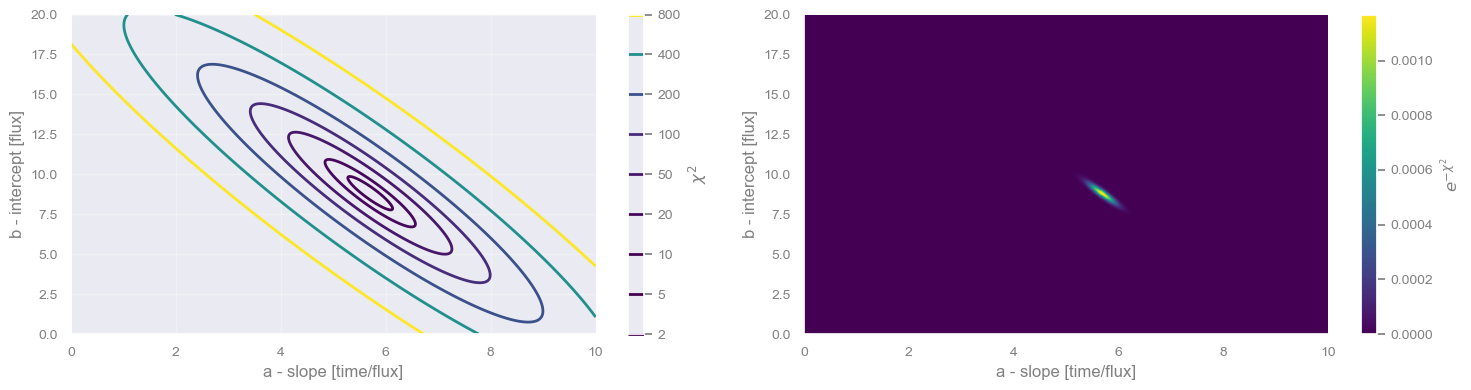

In [11]:
### CPU

t0 = time.time()
chi2_surf,like_surf = CPU_full_chi2(a_grid,b_grid,N_a,N_b,t,f,e,N_data)
t1 = time.time()
cpu_time = t1-t0
print("CPU time: ", cpu_time) 

plot_likelihood_surf(a_grid,b_grid,chi2_surf,like_surf)

GPU time:  0.032746076583862305
Speed up: 0.00


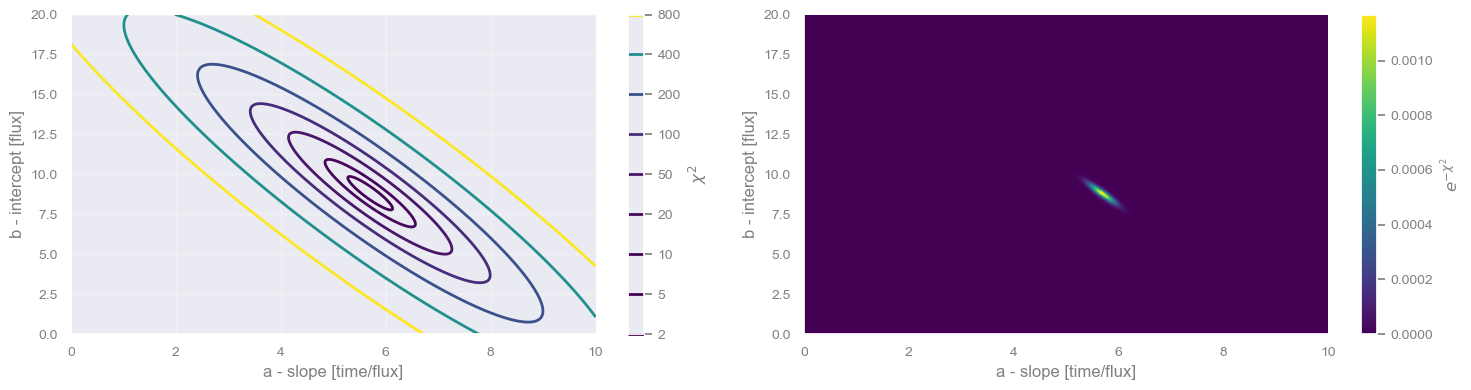

In [14]:
### GPU

t0 = time.time()
chi2_surf_gpu,like_surf_gpu = GPU_set_run_chi2(a_grid,b_grid,N_a,N_b,blocks_per_grid,threads_per_block,t,f,e,N_data)
t1 = time.time()
gpu_time = t1-t0
print("GPU time: ",gpu_time)
speedup = float(gpu_time)/float(cpu_time)
print("Speed up: {speedup:.2f}".format(speedup=speedup))

plot_likelihood_surf(a_grid,b_grid,chi2_surf_gpu,like_surf_gpu)

In [ ]:


# Repeat by increasing the data error bars

# Repeat with more data

# Did you break the GPU? :)

In [ ]:
#EOF